In [1]:
import os
os.chdir("../../")
print(os.getcwd())

C:\Users\ismae\Desktop\PhD_codes\EncoderTransformerDecoder


In [2]:
import torch 
print(torch.cuda.is_available())

True


In [3]:
import torch, pickle, os
from torch.utils.data import Dataset, DataLoader
from src_param.PreProc_Data.DataProc import StackedSequenceDataset
import numpy as np
from src_param.Eval_MZA import Eval_MZA
import matplotlib.pyplot as plt
import pandas as pd
import csv

In [4]:
torch.cuda.empty_cache()
exp_dir = "Trained_Models/2DCyl_new"

exp_name = "sl10_obs4_bs64_attblks1_atthds8_tr0_ph10_lbdaStateLoss1.0_nhd64_5e-05__"
model = Eval_MZA(exp_dir, exp_name)

########## Imp Info ##########
System:  2DCyl


Epoch with Minimum train_error:  3
Epoch with Minimum test_error:  3


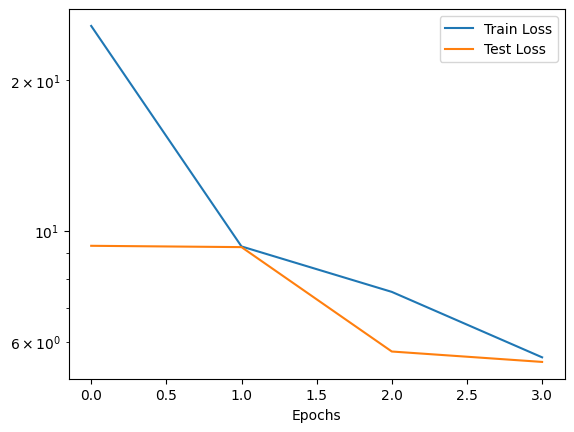

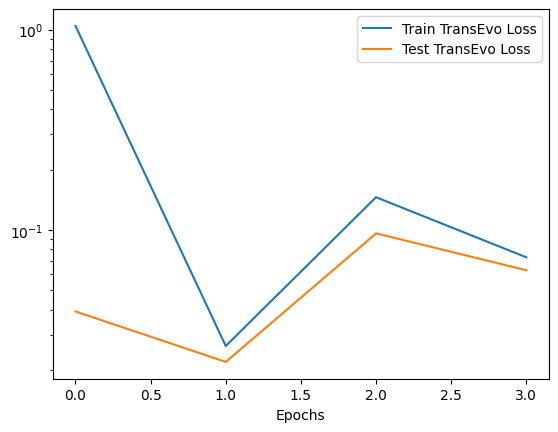

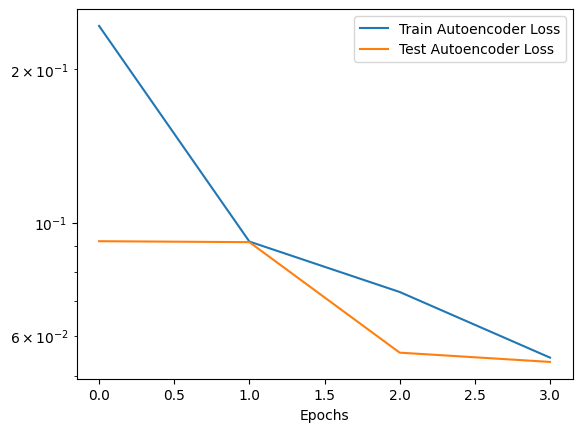

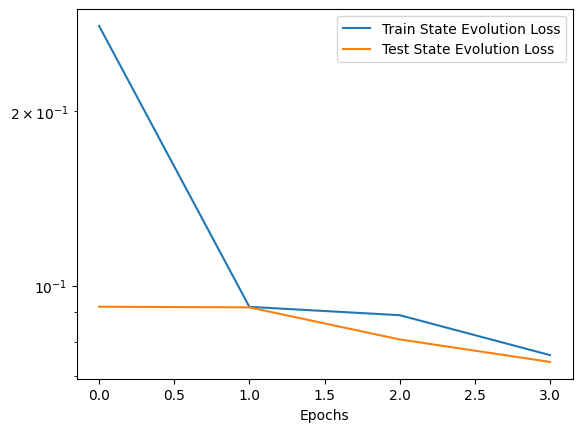

In [5]:
model.plot_learning_curves()

In [6]:
model.load_weights(min_test_loss = True)

In [7]:
model.load_and_preproc_data()
model.create_dataset(mode = "Test")
dataset = model.test_dataset
Phi_test = model.test_data
Phi_test = torch.from_numpy(Phi_test).to(torch.float32).to(model.device)
Phi_test.shape

State Dims:  6550
Test_Shape:  (9, 1516, 6552)
Time:  0.5853796005249023


torch.Size([9, 1516, 6552])

In [8]:
timesteps = 2000
initial_step = 0
initial_conditions = Phi_test[:,initial_step,:]
initial_conditions.shape

torch.Size([9, 6552])

In [ ]:
x_ms_hat, Phi_ms_hat = [], []
nbr_ext_var = 1
print("ic shape:", initial_conditions.shape)

for i in range(initial_conditions.shape[0]):
    initial_condition = initial_conditions[i, :]
    initial_Phi, context = torch.split(initial_condition, [initial_condition.shape[-1]-nbr_ext_var, nbr_ext_var], dim=-1)
    x_hat_temp, Phi_hat_temp = model.predict_multistep(initial_Phi.unsqueeze(0), timesteps, context.unsqueeze(0))
    x_ms_hat.append(x_hat_temp)
    Phi_ms_hat.append(Phi_hat_temp)

x_ms_hat = torch.cat(x_ms_hat, dim = 0)
Phi_ms_hat = torch.cat(Phi_ms_hat, dim = 0)
print(Phi_ms_hat.shape, x_ms_hat.shape)

In [ ]:
#Predicted Velocity
U_ms_hat = Phi_ms_hat[...,:int(Phi_ms_hat.shape[-1]/2)].detach().cpu().numpy()
V_ms_hat = Phi_ms_hat[...,int(Phi_ms_hat.shape[-1]/2):].detach().cpu().numpy()


#DNS Velocity
U = Phi_test[...,:int(Phi_test.shape[-1]/2)].detach().cpu().numpy()
V = Phi_test[...,int(Phi_test.shape[-1]/2):].detach().cpu().numpy()

In [ ]:
def energy(u,v):
    k = 0.5*(np.mean(u**2,axis=-1) + np.mean(v**2,axis=-1))
    return k

for i in range(Phi.shape[0]) : 
    print(round(context[i][0][0].item()*140, 0), round(context[i][0][1].item()*1.5,1))
    k = energy(U[i, :, :], V[i, :, :])
    k_ms_pred = energy(U_ms_hat[i, :, :], V_ms_hat[i, :, :])
    print(k_ms_pred.shape)
    plt.plot(np.arange(k_ms_pred.shape[-1]), k_ms_pred, label="AE")
    plt.plot(np.arange(k.shape[-1]), k[initial_step:], label="DNS", color="brown")
    plt.title(r"Kinetic Energy Re = {}, $\beta$ = {}".format(round(context[i][0][0].item()*140, 0), round(context[i][0][1].item()*1.5,1)))
    plt.legend(loc='lower right')
    plt.xlabel(r"t")
    plt.ylabel("Kinetic Energy")
    plt.show()